In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread

In [ ]:
!pip install -U gdown


In [ ]:
import gdown

# File ID
file_id = '1-Hx0D4jRYwP8LVhbalNgjYY4I-41Dg9a'
# Output name
output = 'cell_images_split.zip'

# Download from Google Drive
gdown.download(id=file_id, output=output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1-Hx0D4jRYwP8LVhbalNgjYY4I-41Dg9a
From (redirected): https://drive.google.com/uc?id=1-Hx0D4jRYwP8LVhbalNgjYY4I-41Dg9a&confirm=t&uuid=e4ff258f-0bfe-4427-859d-8dbdcc584bbe
To: /content/cell_images_split.zip
100%|██████████| 356M/356M [00:06<00:00, 57.6MB/s]


'cell_images_split.zip'

In [ ]:
!unzip -q cell_images_split.zip


In [ ]:
my_data_dir = '/content/cell_images/cell_images'
train_path = my_data_dir + '/train/'
test_path = my_data_dir + '/test/'


In [ ]:
os.listdir(test_path)

['parasitized', 'uninfected']

In [ ]:
os.listdir(train_path)

['parasitized', 'uninfected']

In [ ]:
os.listdir(train_path+'/parasitized')[2]

'C48P9thinF_IMG_20150721_160944_cell_231.png'

In [ ]:
para_cell = train_path+'/parasitized'+'/C100P61ThinF_IMG_20150918_144104_cell_164.png'

In [ ]:
para_img= imread(para_cell)

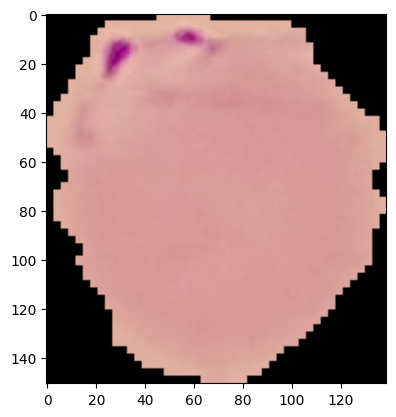

In [ ]:
plt.imshow(para_img)

In [ ]:
para_img.shape

(151, 139, 3)

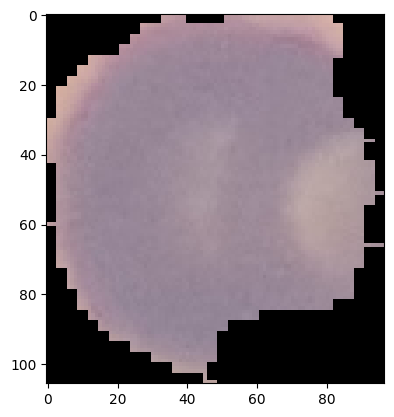

In [ ]:
unifected_cell_path = train_path+'/uninfected/'+os.listdir(train_path+'/uninfected')[5]
unifected_cell = imread(unifected_cell_path)
plt.imshow(unifected_cell)

In [ ]:
len(os.listdir(train_path+'/parasitized'))

12480

In [ ]:
len(os.listdir(train_path+'/uninfected'))

12480

In [ ]:
unifected_cell.shape

(106, 97, 3)

In [ ]:
para_img.shape

(151, 139, 3)

In [ ]:
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'/uninfected'):

    img = imread(test_path+'/uninfected'+'/'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

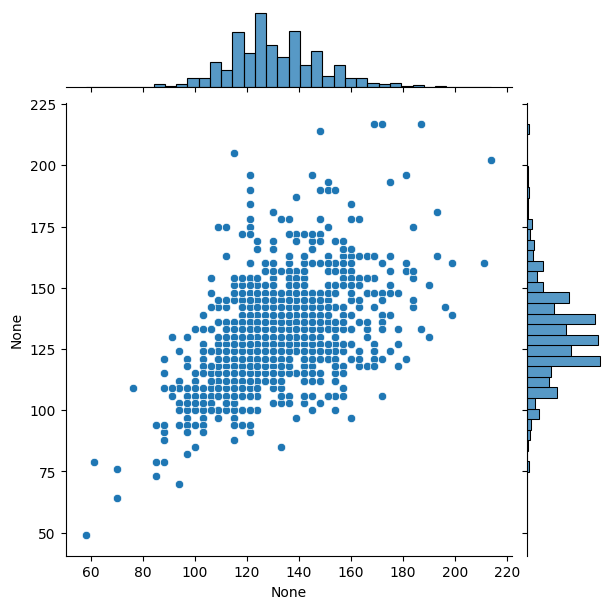

In [ ]:
sns.jointplot(x=dim1,y=dim2)

In [ ]:
np.mean(dim1)

np.float64(130.92538461538462)

In [ ]:
np.mean(dim2)

np.float64(130.75)

In [ ]:
image_shape = (130,130,3)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
image_gen = ImageDataGenerator(rotation_range=20,
                               width_shift_range=0.10,
                               height_shift_range=0.10,
                               rescale=1/255,
                               shear_range=0.1,
                               zoom_range=0.1,
                               horizontal_flip=True,
                               fill_mode='nearest'
                              )

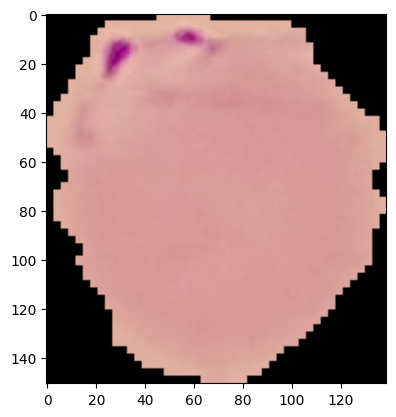

In [ ]:
plt.imshow(para_img)

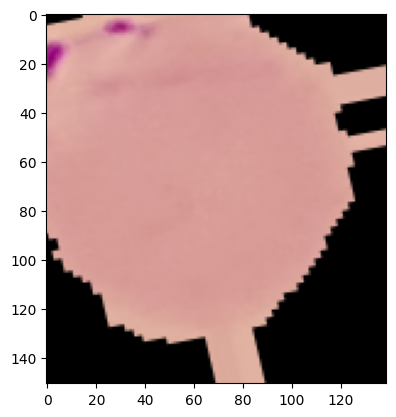

In [ ]:
plt.imshow(image_gen.random_transform(para_img))

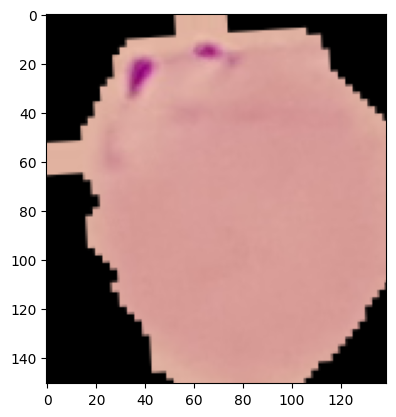

In [ ]:
plt.imshow(image_gen.random_transform(para_img))

In [ ]:
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


In [ ]:
image_gen.flow_from_directory(test_path)

Found 2600 images belonging to 2 classes.


## Creating the Model VGG16

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load VGG16 base (without top)
vgg_base = VGG16(include_top=False, input_shape=image_shape, weights='imagenet')
vgg_base.trainable = False  # Freeze all layers

# Build model on top of VGG16
model = Sequential()
model.add(vgg_base)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint('best_vgg16_model.h5', monitor='val_loss', save_best_only=True, verbose=1)


In [ ]:
batch_size = 32

In [ ]:
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Found 24958 images belonging to 2 classes.


In [ ]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',
                                               shuffle=False)

Found 2600 images belonging to 2 classes.


In [ ]:
history = model.fit(
    train_image_gen,
    epochs=20,
    validation_data=test_image_gen,
    callbacks=[early_stop, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.6645 - loss: 0.6136
Epoch 1: val_loss improved from inf to 0.41719, saving model to best_vgg16_model.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 139s 167ms/step - accuracy: 0.6646 - loss: 0.6135 - val_accuracy: 0.8404 - val_loss: 0.4172
Epoch 2/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8514 - loss: 0.3895
Epoch 2: val_loss improved from 0.41719 to 0.31838, saving model to best_vgg16_model.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 121s 155ms/step - accuracy: 0.8514 - loss: 0.3895 - val_accuracy: 0.8731 - val_loss: 0.3184
Epoch 3/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8791 - loss: 0.3175
Epoch 3: val_loss improved from 0.31838 to 0.28181, saving model to best_vgg16_model.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 121s 155ms/step - accuracy: 0.8791 - loss: 0.3175 - val_accuracy: 0.8904 - val_loss: 0.2818
Epoch 4/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8961 - loss: 0.2761
Epoch 4: val_loss improved from 0.28181 to 0.25036, saving model to best_vgg16_model.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 121s 155ms/step - accuracy: 0.8961 - loss: 0.2761 - val_accuracy: 0.8977 - val_loss: 0.2504
Epoch 5/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.9027 - loss: 0.2505
Epoch 5: val_loss improved from 0.25036 to 0.23758, saving model to best_vgg16_model.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 121s 154ms/step - accuracy: 0.9027 - loss: 0.2505 - val_accuracy: 0.9112 - val_loss: 0.2376
Epoch 6/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9081 - loss: 0.2422
Epoch 6: val_loss improved from 0.23758 to 0.22745, saving model to best_vgg16_model.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 121s 155ms/step - accuracy: 0.9081 - loss: 0.2422 - val_accuracy: 0.9162 - val_loss: 0.2274
Epoch 7/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9132 - loss: 0.2278
Epoch 7: val_loss did not improve from 0.22745
780/780 ━━━━━━━━━━━━━━━━━━━━ 121s 155ms/step - accuracy: 0.9132 - loss: 0.2278 - val_accuracy: 0.9046 - val_loss: 0.2319
Epoch 8/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9158 - loss: 0.2228
Epoch 8: val_loss did not improve from 0.22745
780/780 ━━━━━━━━━━━━━━━━━━━━ 122s 156ms/step - accuracy: 0.9158 - loss: 0.2228 - val_accuracy: 0.9073 - val_loss: 0.2276
Epoch 9/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.9171 - loss: 0.2201
Epoch 9: val_loss improved from 0.22745 to 0.22247, saving model to best_vgg16_model.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 123s 157ms/step - accuracy: 0.9171 - loss: 0.2201 - val_accuracy: 0.9123 - val_loss: 0.2225
Epoch 10/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9188 - loss: 0.2165
Epoch 10: val_loss improved from 0.22247 to 0.20873, saving model to best_vgg16_model.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 121s 155ms/step - accuracy: 0.9188 - loss: 0.2165 - val_accuracy: 0.9173 - val_loss: 0.2087
Epoch 11/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9176 - loss: 0.2134
Epoch 11: val_loss improved from 0.20873 to 0.20641, saving model to best_vgg16_model.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 121s 154ms/step - accuracy: 0.9176 - loss: 0.2134 - val_accuracy: 0.9204 - val_loss: 0.2064
Epoch 12/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9206 - loss: 0.2141
Epoch 12: val_loss did not improve from 0.20641
780/780 ━━━━━━━━━━━━━━━━━━━━ 121s 156ms/step - accuracy: 0.9206 - loss: 0.2141 - val_accuracy: 0.9158 - val_loss: 0.2154
Epoch 13/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9239 - loss: 0.2080
Epoch 13: val_loss did not improve from 0.20641
780/780 ━━━━━━━━━━━━━━━━━━━━ 122s 156ms/step - accuracy: 0.9239 - loss: 0.2080 - val_accuracy: 0.9200 - val_loss: 0.2087
Epoch 14/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9238 - loss: 0.2044
Epoch 14: val_loss improved from 0.20641 to 0.19564, saving model to best_vgg16_model.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 122s 156ms/step - accuracy: 0.9238 - loss: 0.2044 - val_accuracy: 0.9265 - val_loss: 0.1956
Epoch 15/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9219 - loss: 0.2095
Epoch 15: val_loss did not improve from 0.19564
780/780 ━━━━━━━━━━━━━━━━━━━━ 121s 155ms/step - accuracy: 0.9219 - loss: 0.2095 - val_accuracy: 0.9227 - val_loss: 0.2045
Epoch 16/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.9261 - loss: 0.2007
Epoch 16: val_loss did not improve from 0.19564
780/780 ━━━━━━━━━━━━━━━━━━━━ 121s 155ms/step - accuracy: 0.9261 - loss: 0.2007 - val_accuracy: 0.9169 - val_loss: 0.2090
Epoch 17/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9266 - loss: 0.1986
Epoch 17: val_loss did not improve from 0.19564
780/780 ━━━━━━━━━━━━━━━━━━━━ 121s 155ms/step - accuracy: 0.9266 - loss: 0.1986 - val_accuracy: 0.9304 - val_loss: 0.2014
Epoch 18/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9268 - loss: 0.1981
Epoch 18: val_lo

780/780 ━━━━━━━━━━━━━━━━━━━━ 122s 156ms/step - accuracy: 0.9268 - loss: 0.1981 - val_accuracy: 0.9315 - val_loss: 0.1924
Epoch 19/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9256 - loss: 0.1990
Epoch 19: val_loss did not improve from 0.19237
780/780 ━━━━━━━━━━━━━━━━━━━━ 122s 156ms/step - accuracy: 0.9256 - loss: 0.1990 - val_accuracy: 0.9277 - val_loss: 0.1978
Epoch 20/20
780/780 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.9306 - loss: 0.1911
Epoch 20: val_loss improved from 0.19237 to 0.19151, saving model to best_vgg16_model.h5


780/780 ━━━━━━━━━━━━━━━━━━━━ 122s 156ms/step - accuracy: 0.9306 - loss: 0.1911 - val_accuracy: 0.9288 - val_loss: 0.1915


<Axes: title={'center': 'Accuracy'}>

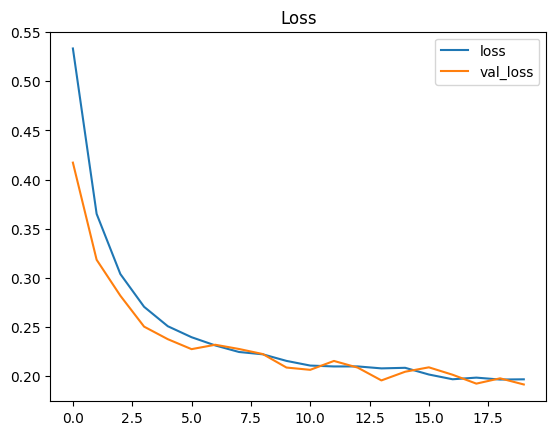

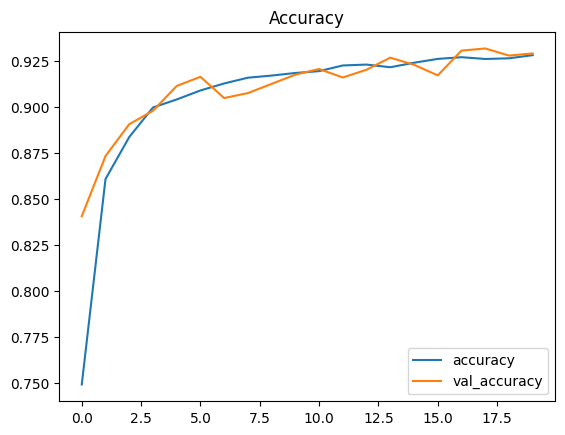

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

losses = pd.DataFrame(history.history)

losses[['loss', 'val_loss']].plot(title='Loss')
losses[['accuracy', 'val_accuracy']].plot(title='Accuracy')


In [ ]:
# Evaluate
model.evaluate(test_image_gen)

# Predict probabilities
pred_probs = model.predict(test_image_gen)

# Use 0.80 threshold
predictions = pred_probs > 0.80

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(test_image_gen.classes, predictions.astype(int)))
print(confusion_matrix(test_image_gen.classes, predictions.astype(int)))


82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - accuracy: 0.9107 - loss: 0.1996
82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step
              precision    recall  f1-score   support

           0       0.85      0.96      0.90      1300
           1       0.95      0.83      0.89      1300

    accuracy                           0.89      2600
   macro avg       0.90      0.89      0.89      2600
weighted avg       0.90      0.89      0.89      2600

[[1246   54]
 [ 225 1075]]
